In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from scipy import cluster
from sklearn.manifold import TSNE
from sklearn import cluster, metrics
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from nltk.cluster import KMeansClusterer

df = pd.read_csv('Technology Skills.csv')
df.head()

,O*NET-SOC Code,Title,Example,Commodity Code,Commodity Title,Hot Technology
0,11-1011.00,Chief Executives,Adobe Systems Adobe Acrobat,43232202,Document management software,Y
1,11-1011.00,Chief Executives,AdSense Tracker,43232306,Data base user interface and query software,N
2,11-1011.00,Chief Executives,Atlassian JIRA,43232201,Content workflow software,Y
3,11-1011.00,Chief Executives,Blackbaud The Raiser's Edge,43232303,Customer relationship management CRM software,Y
4,11-1011.00,Chief Executives,ComputerEase Construction Accounting,43231601,Accounting software,N


In [2]:
df['Hot Technology'] = [x in ['Y'] for x in df['Hot Technology']]
df.head()

,O*NET-SOC Code,Title,Example,Commodity Code,Commodity Title,Hot Technology
0,11-1011.00,Chief Executives,Adobe Systems Adobe Acrobat,43232202,Document management software,True
1,11-1011.00,Chief Executives,AdSense Tracker,43232306,Data base user interface and query software,False
2,11-1011.00,Chief Executives,Atlassian JIRA,43232201,Content workflow software,True
3,11-1011.00,Chief Executives,Blackbaud The Raiser's Edge,43232303,Customer relationship management CRM software,True
4,11-1011.00,Chief Executives,ComputerEase Construction Accounting,43231601,Accounting software,False


In [3]:
df_transformed = df.groupby(['Commodity Title']).sum()
df_transformed['Commodity Title'] = df_transformed.index
df_transformed.reset_index(drop=True, inplace=True)
df_transformed.head()

,Commodity Code,Hot Technology,Commodity Title
0,2766905664,34.0,Access software
1,20924094884,146.0,Accounting software
2,172928004,0.0,Action games
3,1945476180,0.0,Administration software
4,119927246270,354.0,Analytical or scientific software


In [4]:
def tokenize_data(unique_types):
    tokenized_data = []

    # iterate through each sentence in the file
    for i in unique_types:
        for j in sent_tokenize(i):
            # tokenize the sentence into words
            temp = [k.lower() for k in word_tokenize(i)]
            tokenized_data.append(temp)

    return(tokenized_data)


def sent_vectorizer(sent, model):
    sent_vec = []
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw += 1
        except:
            pass

    return np.asarray(sent_vec) / numw


def tokenize_and_vectorize(data):  
    tokenized_data = tokenize_data(data)
    model = Word2Vec(tokenize_data(data), min_count=1)
    return [sent_vectorizer(phrase, model) for phrase in tokenized_data]


def add_feature(df, cols, vectorized_data):
    df[cols] = StandardScaler().fit_transform(df[cols])
    return [np.append(element, df.loc[index, cols])
            for index, element in enumerate(vectorized_data)]


def clustering_results(vectorized_data, labels, metric='euclidean', verbose=False):
    # Print Silhouette Score
    silhouette_score = metrics.silhouette_score(vectorized_data,
                                                labels,
                                                metric=metric)

    print("Silhouette_score: {} ".format(silhouette_score))
    
    #Print Scatter Plot of Clusters
    model = TSNE(n_components=2, random_state=12345)
    np.set_printoptions(suppress=True)

    Y=model.fit_transform(vectorized_data)
    plt.scatter(Y[:, 0], Y[:, 1], c=labels, s=290,alpha=.5)

    for j in range(len(vectorized_data)):    
        plt.annotate(labels[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')

    plt.show()
    
    if verbose:
        for index, sentence in enumerate(tokenized_data):
            print(str(labels[index]) + ":" + str(sentence))

# Standard Tokenizer and Vectorizer

## Tokenize and Vectorize Data

In [5]:
vectorized_data = tokenize_and_vectorize(df_transformed['Commodity Title'])
cluster_data = add_feature(df_transformed, ['Hot Technology'], vectorized_data)

/Users/andrewmartinez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/Users/andrewmartinez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


## KMeans: NTLK Implementation

### Text Vectorization Only

Silhouette_score: 0.00043051561806350946 


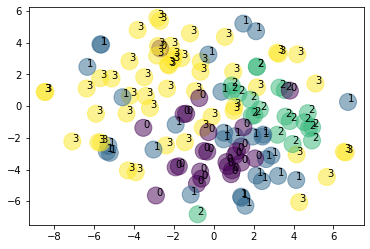

In [6]:
NUM_CLUSTERS = 4
kclusterer = KMeansClusterer(NUM_CLUSTERS,
                             distance=nltk.cluster.util.cosine_distance,
                             repeats=10)
labels = kclusterer.cluster(vectorized_data,
                            assign_clusters=True)

clustering_results(vectorized_data, labels)

### Hot Technology Count

Silhouette_score: 0.15095653001532786 


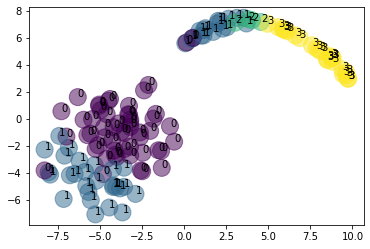

In [13]:
NUM_CLUSTERS = 4
kclusterer = KMeansClusterer(NUM_CLUSTERS,
                             distance=nltk.cluster.util.cosine_distance,
                             repeats=10)
labels = kclusterer.cluster(cluster_data,
                            assign_clusters=True)

clustering_results(cluster_data, labels)

## KMeans: SKLearn Implementation

### Text Vectorization Only

Text(0.5, 1.0, 'Elbow curve')

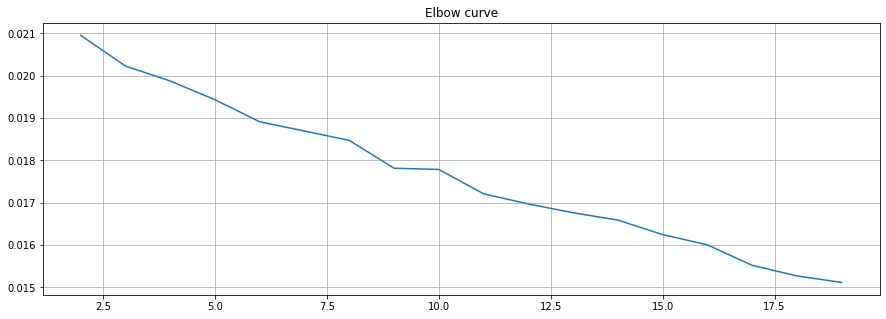

In [14]:
distorsions = []
for k in range(2, 20):
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(vectorized_data)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')


Silhouette_score: 0.052197884768247604 


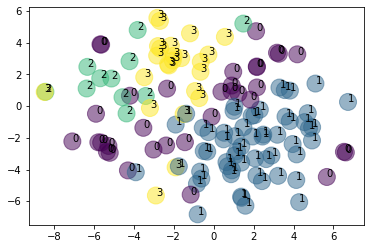

In [15]:
kmeans = cluster.KMeans(n_clusters=4)
kmeans.fit(vectorized_data)
labels = kmeans.labels_
  
clustering_results(vectorized_data, labels)

### Hot Technology Count

Text(0.5, 1.0, 'Elbow curve')

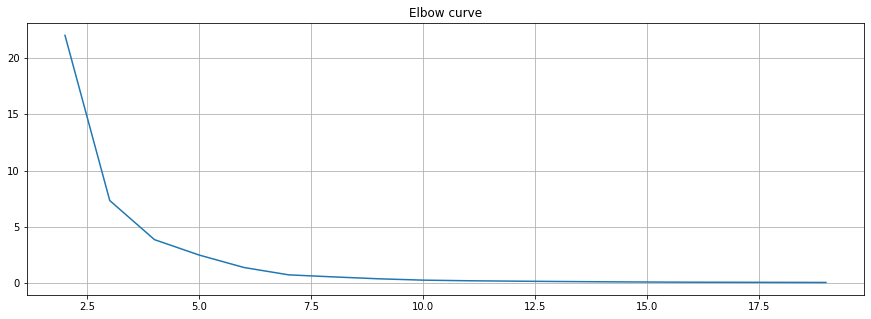

In [16]:
distorsions = []
for k in range(2, 20):
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(cluster_data)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')


Silhouette_score: 0.8205463907376347 


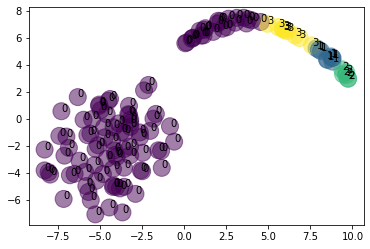

In [30]:
kmeans = cluster.KMeans(n_clusters=4)
kmeans.fit(cluster_data)
labels = kmeans.labels_
  
clustering_results(cluster_data, labels)

In [31]:
cluster_df = df_transformed.copy()
cluster_df['clusters'] = labels
cluster_df.head()

,Commodity Code,Hot Technology,Commodity Title,clusters
0,2766905664,-0.285288,Access software,0
1,20924094884,0.217243,Accounting software,3
2,172928004,-0.437842,Action games,0
3,1945476180,-0.437842,Administration software,0
4,119927246270,1.150516,Analytical or scientific software,1


In [32]:
cluster_df[cluster_df.clusters == 0]

,Commodity Code,Hot Technology,Commodity Title,clusters
0,2766905664,-0.285288,Access software,0
2,172928004,-0.437842,Action games,0
3,1945476180,-0.437842,Administration software,0
5,5058226017,-0.038510,Application server software,0
6,43231516,-0.437842,Audit software,0
7,302632407,-0.437842,Authentication server software,0
8,86465202,-0.437842,Aviation ground support software,0
9,2507538070,-0.437842,Backup or archival software,0
10,86463018,-0.437842,Bar coding software,0
11,43232913,-0.437842,Bridge software,0


In [33]:
cluster_df[cluster_df.clusters == 1]

,Commodity Code,Hot Technology,Commodity Title,clusters
4,119927246270,1.150516,Analytical or scientific software,1
36,39384718222,1.908800,Development environment software,1
40,39126318405,2.092762,Electronic mail software,1
55,39254748616,1.352426,Graphics or photo imaging software,1
89,29700662235,1.881878,Object or component oriented development software,1
92,28187918608,1.863931,Operating system software,1
99,26328352554,1.958155,Presentation software,1
104,30002665858,1.244740,Project management software,1
124,29484502256,1.953669,Web platform development software,1


In [34]:
cluster_df[cluster_df.clusters == 2]

,Commodity Code,Hot Technology,Commodity Title,clusters
21,45134838576,4.246468,Computer aided design CAD software,2
30,102157939078,3.600356,Data base user interface and query software,2
42,45220255692,4.255442,Enterprise resource planning ERP software,2
91,36400933946,2.985653,Office suite software,2
109,45393715500,3.376012,Spreadsheet software,2
126,50840954304,3.398446,Word processing software,2


In [35]:
cluster_df[cluster_df.clusters == 3]

,Commodity Code,Hot Technology,Commodity Title,clusters
1,20924094884,0.217243,Accounting software,3
12,10159593790,0.504404,Business intelligence and data analysis software,3
27,14612518414,0.019820,Customer relationship management CRM software,3
28,18416961504,0.980014,Data base management system software,3
39,17509041810,0.145453,Document management software,3
41,8473550988,0.226217,Enterprise application integration software,3
73,20838549892,0.253138,Map creation software,3
75,65670334590,0.621063,Medical software,3
123,12277918388,0.298007,Web page creation and editing software,3


In [29]:
cluster_df[cluster_df.clusters == 4]

,Commodity Code,Hot Technology,Commodity Title,clusters
1,20924094884,0.217243,Accounting software,4
5,5058226017,-0.038510,Application server software,4
12,10159593790,0.504404,Business intelligence and data analysis software,4
27,14612518414,0.019820,Customer relationship management CRM software,4
39,17509041810,0.145453,Document management software,4
41,8473550988,0.226217,Enterprise application integration software,4
73,20838549892,0.253138,Map creation software,4
75,65670334590,0.621063,Medical software,4
123,12277918388,0.298007,Web page creation and editing software,4
